## CS224 - Winter 2025
## HW 3: Dog Denoiser

Submit **PDF** of completed IPython notebook on **Canvas**

**Due**: March 14, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Ranjitha Narasimhamurthy

  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment, we will make a linear and nonlinear dog denoiser (inspired by the need to restore a damaged image of Sri Sri Fluffles-ji to his former glory as discussed in class).
Complete all the code marked `TODO`.

### Import libraries, data, viz data
This section can remain unchanged.

Using device: cpu
Example images of CIFAR-10 dogs


<ipython-input-3-d3eb2942bdc7>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dogs_train, dogs_val = torch.load('hw3_data.pt', map_location=device)


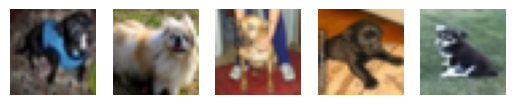

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet

def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened.
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# datasets are small enough to be loaded on GPU
# usually we leave on CPU and only put the training batch on GPU
dogs_train, dogs_val = torch.load('hw3_data.pt', map_location=device)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

def test_model(model, val_loader=val_loader):
    """Code to test MSE on validation data."""
    criterion = nn.MSELoss()
    model.eval()
    mse = 0.
    with torch.no_grad():
        for x, in val_loader:
            x_noise = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noise).view(x.shape)
            mse += criterion(x, x_hat) / len(val_loader)
    return mse

print("Example images of CIFAR-10 dogs")
fig = show_image(dogs_train[:5])

### Linear denoiser (6 points)

We will use PCA to define a linear denoiser.
First, we encode the data into a latent factor using the top 500 principal components, then we decode to recover a (denoised) version of the image that lies on the linear subspace spanned by the first 500 components.
I found it convenient to put a "flatten" operation inside fit and forward, so I could just input the images directly with the same shape as for the UNet.

In [ ]:
class LinearDenoiser(nn.Module):
    """Denoise by projecting onto linear subspace spanned by
    top principal components."""
    def __init__(self, d=500):
        super(LinearDenoiser, self).__init__()
        self.d = d  # Number of principal components to use
        # We won't use backprop on this model,
        # so you can store parameters however you like
        self.mean = None  # Mean of dataset
        self.components = None  # Principal components

    def forward(self, x):
        x = x.flatten(start_dim=1)  # Flatten images to vectors
        z = self.encode(x)
        x_hat = self.decode(z)
        x_hat = x_hat.reshape(-1, 3, 32, 32)  # Unflatten back to image
        return x_hat

    def encode(self, x):
        # TODO [1 points]: encode x into low-d latent space
        x = x.flatten(start_dim=1) - self.mean  # Center input
        z = torch.mm(x, self.components.T)  # Project onto principal components
        return z

    def decode(self, z):
        # TODO [1 points]: linearly decode back to x-space
        x_hat = torch.mm(z, self.components) + self.mean  # Reconstruct using principal components
        return x_hat

    def fit(self, x):
        x = x.flatten(start_dim=1)  # Flatten images
        self.mean = x.mean(dim=0)  # Compute mean
        x_centered = x - self.mean  # Center data

        # TODO [4 points]: Use PCA to get the parameters
        # Don't forget store the mean
        # to center data and for reconstruction.
        # Use SVD to get eigenvectors of covariance, like I did in class
        U, S, Vt = torch.linalg.svd(x_centered, full_matrices=False)  # Efficient SVD
        self.components = Vt[:self.d, :]  # Store top d principal components

linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

In [ ]:
# Please run this test code (no need to edit)
linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

test_batch = dogs_train[:10]
flat_test_batch = test_batch.flatten(start_dim=1)
z = linear_model.encode(flat_test_batch)
_, k = z.shape
x_hat = linear_model.decode(z)
_, d = x_hat.shape
x_hat_forward = linear_model(test_batch)
assert d == 3072, 'x_hat size should be 32*32*3'
assert k == linear_model.d, 'Encoded signal size is wrong'
assert x_hat_forward.shape == test_batch.shape
print('all tests passed')

all tests passed


### Train U-Net [5 points]
Use the included U-Net, and train it to denoise images
by minimizing the Mean Square Error loss (nn.MSELoss) between images and reconstructions from a noisy version of the image.
Use a noise standard deviation of 0.1 for the Gaussian noise.
Train with SGD.

In [ ]:
# TODO [5 points]
# Train the UNet.
# This one is a little slow to train.
# I got reasonable results in 20 epochs on my laptop, in about 30 mins
# However, you might want to learn how to use cuda() on colab
# to dramatically speed this up.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet  # Importing the provided U-Net model

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset onto CPU to avoid memory issues
dogs_train, dogs_val = torch.load("hw3_data.pt", map_location="cpu")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(dogs_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=batch_size, shuffle=False)

# Define training function
def train_unet(model, train_loader, epochs=20, lr=0.01):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, in train_loader:
            x = x.to(device)
            x_noise = x + 0.1 * torch.randn_like(x)  # Adding Gaussian noise (std = 0.1)

            optimizer.zero_grad()
            x_hat = model(x_noise).view(x.shape)  # Denoise using U-Net
            loss = criterion(x_hat, x)  # Compute MSE loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Instantiate and train the U-Net model
model = UNet().to(device)
train_unet(model, train_loader)

#model = UNet()


Using device: cpu


<ipython-input-7-905aead57981>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dogs_train, dogs_val = torch.load("hw3_data.pt", map_location="cpu")


Epoch 1/20, Loss: 0.0524
Epoch 2/20, Loss: 0.0072
Epoch 3/20, Loss: 0.0060
Epoch 4/20, Loss: 0.0052
Epoch 5/20, Loss: 0.0048
Epoch 6/20, Loss: 0.0044
Epoch 7/20, Loss: 0.0045
Epoch 8/20, Loss: 0.0043
Epoch 9/20, Loss: 0.0040
Epoch 10/20, Loss: 0.0040
Epoch 11/20, Loss: 0.0039
Epoch 12/20, Loss: 0.0039
Epoch 13/20, Loss: 0.0038
Epoch 14/20, Loss: 0.0036
Epoch 15/20, Loss: 0.0035
Epoch 16/20, Loss: 0.0035
Epoch 17/20, Loss: 0.0035
Epoch 18/20, Loss: 0.0033
Epoch 19/20, Loss: 0.0032
Epoch 20/20, Loss: 0.0033


###  Results [4 points]

You shouldn't need to change the code below. It just prints out denoised images and validation loss using your trained UNet and fitted Linear model.

4 points for getting correct looking results. It should be possible to get MSE below 0.01 (value for no denoising at all), and the denoised images should be noticeably better, for linear and nonlinear denoisers

Original images


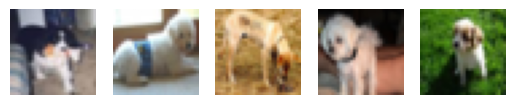

Noisy images


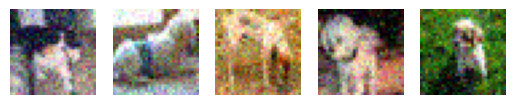

Linear denoising


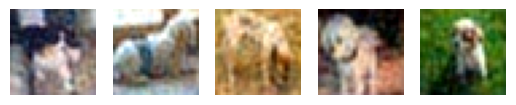

UNet denoising


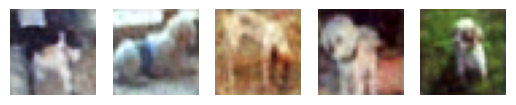

Linear model Val MSE: 0.0026
UNet Val MSE: 0.0025


In [ ]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)  # Done on CPU to avoid MPS bug!
with torch.no_grad():
    linear_denoise = linear_model(noisy_dogs.to(device)).cpu()
    unet_denoise = model(noisy_dogs.to(device)).cpu()

print("Original images")
show_image(dogs)
plt.show()
print("Noisy images")
show_image(noisy_dogs)
plt.show()
print("Linear denoising")
show_image(linear_denoise)
plt.show()
print("UNet denoising")
show_image(unet_denoise)
plt.show()

linear_mse = test_model(linear_model)
unet_mse = test_model(model)
print(f"Linear model Val MSE: {linear_mse:.4f}")
print(f"UNet Val MSE: {unet_mse:.4f}")

###  Extra credit
We won't have time for grading since we're near the end of class, so you can get at most one point for trying the following three experiments.
- What happens if you put a dog image with no noise through the denoiser, then denoise that result, and continue repeating? Will it converge to some fixed point?
- What happens if you instead use an image that differs significantly from training? For instance, will noisy cats get turned into dogs through repeated denoising?
 - If we put pure Gaussian noise in, and repeatedly denoise, will we eventually get something dog-like?

Basically, the idea is just repeatedly denoising on three different types of images: a dog image, a cat image, and a Gaussian image. Print out the original image and the results after each denoising step.
